# Lab J2 — Matin : Classification Binaire & Perceptron Multiclasse
**Formation IA, Deep Learning & Machine Learning** — Julien Rolland
**Public :** M2 Développement Fullstack

---

## Objectifs

- Explorer le dataset `digits` (sklearn) — images 8×8, 10 classes
- Implémenter le perceptron de Rosenblatt binaire en NumPy
- Généraliser au cas multiclasse : $K$ perceptrons + softmax from scratch
- Dériver et coder les gradients de la CCE pour $\mathbf{W}$ et $\mathbf{b}$
- Comparer avec scikit-learn

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

np.random.seed(42)

print('NumPy :', np.__version__)

NumPy : 2.4.2


---
## Partie 1 — Dataset `digits`

### 1.1 Chargement

In [2]:
digits = load_digits()

X_raw = digits.data    # (1797, 64)  — images 8×8 aplaties
y     = digits.target  # (1797,)     — classes 0–9

print('X shape :', X_raw.shape)
print('y shape :', y.shape)
print('Classes :', np.unique(y))
print('Pixel range : [{:.0f}, {:.0f}]'.format(X_raw.min(), X_raw.max()))

X shape : (1797, 64)
y shape : (1797,)
Classes : [0 1 2 3 4 5 6 7 8 9]
Pixel range : [0, 16]


### 1.2 Visualisation

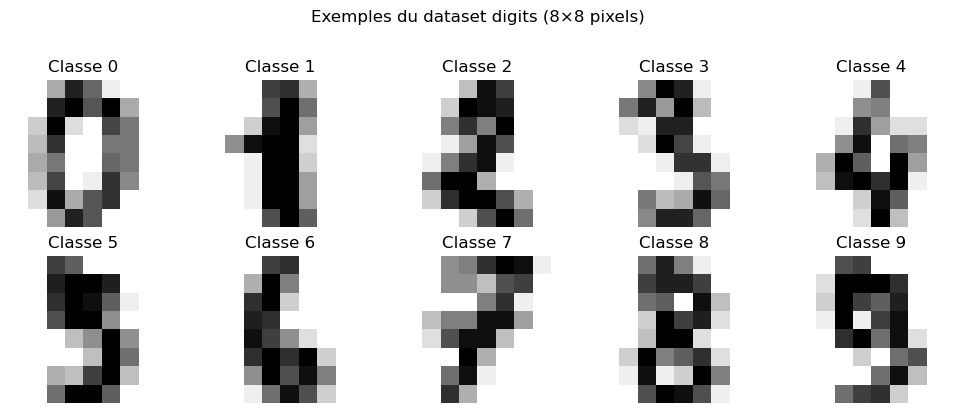

In [3]:
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for ax, img, label in zip(axes.flat, X_raw, y):
    ax.imshow(img.reshape(8, 8), cmap='gray_r')
    ax.set_title(f'Classe {label}')
    ax.axis('off')
plt.suptitle('Exemples du dataset digits (8×8 pixels)', y=1.02)
plt.tight_layout()
plt.show()

### 1.3 Préparation — Normalisation & Split

In [4]:
# Pixels dans [0, 16] → normalisation dans [0, 1]
X = X_raw / 16.0

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print('Train :', X_train.shape, y_train.shape)
print('Test  :', X_test.shape,  y_test.shape)

Train : (1437, 64) (1437,)
Test  : (360, 64) (360,)


---
## Partie 2 — Perceptron Binaire de Rosenblatt (0 vs 1)

### 2.1 Sous-dataset et encodage ±1

In [5]:
# Garder uniquement les classes 0 et 1
mask_train = y_train <= 1
mask_test  = y_test  <= 1

X_bin_train = X_train[mask_train]
X_bin_test  = X_test[mask_test]

# Encodage ±1 (crucial pour la loss de Rosenblatt)
t_bin_train = np.where(y_train[mask_train] == 1,  1, -1)
t_bin_test  = np.where(y_test[mask_test]  == 1,  1, -1)

print('Train binaire :', X_bin_train.shape, '| classes :', np.unique(t_bin_train))
print('Test  binaire :', X_bin_test.shape)

Train binaire : (288, 64) | classes : [-1  1]
Test  binaire : (72, 64)


### 2.2 Algorithme de Rosenblatt

**Règle de mise à jour** (online, un exemple à la fois) :

$$\text{si } \hat{t}_n \neq t_n : \quad \mathbf{w} \leftarrow \mathbf{w} + \alpha\, t_n\, \mathbf{x}_n$$

In [ ]:
def rosenblatt(
    X: np.ndarray,
    t: np.ndarray,
    lr: float = 0.1,
    n_epochs: int = 50,
) -> tuple[np.ndarray, list[int]]:
    """
    Online Rosenblatt perceptron with ±1 encoding.

    Parameters
    ----------
    X        : (N, D)  Features.
    t        : (N,)    Labels in {+1, -1}.
    lr       : float   Learning rate.
    n_epochs : int     Number of passes over the dataset.

    Returns
    -------
    w                : (D+1,)      Weights — w[0] is the absorbed bias.
    errors_per_epoch : list[int]   Number of misclassifications per epoch.
    """
    N, D = X.shape
    X_aug = np.hstack([np.ones((N, 1)), X])  # biais absorbé : w[0] = b
    w = np.zeros(D + 1)
    errors_per_epoch = []

    for _ in range(n_epochs):
        errors = 0
        for n in range(N):
            t_hat = np.sign(X_aug[n] @ w)
            if t_hat != t[n]:
                w += lr * t[n] * X_aug[n]
                errors += 1
        errors_per_epoch.append(errors)

    return w, errors_per_epoch

### 2.3 Entraînement & convergence

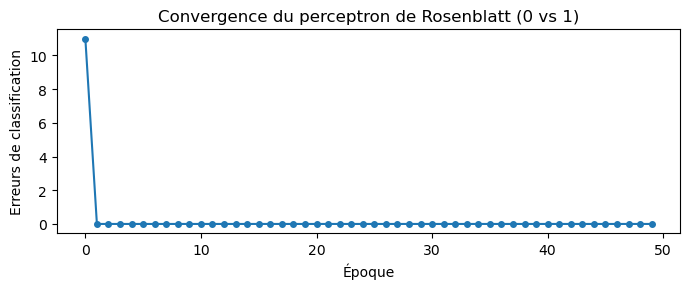

In [7]:
w_bin, errors_history = rosenblatt(X_bin_train, t_bin_train, lr=0.1, n_epochs=50)

fig, ax = plt.subplots(figsize=(7, 3))
ax.plot(errors_history, marker='o', markersize=4)
ax.set_xlabel('Époque')
ax.set_ylabel('Erreurs de classification')
ax.set_title('Convergence du perceptron de Rosenblatt (0 vs 1)')
plt.tight_layout()
plt.show()

### 2.4 Évaluation

In [8]:
X_bin_test_aug = np.hstack([np.ones((X_bin_test.shape[0], 1)), X_bin_test])
t_pred_test    = np.sign(X_bin_test_aug @ w_bin)

acc_bin_train = np.mean(
    np.sign(np.hstack([np.ones((X_bin_train.shape[0], 1)), X_bin_train]) @ w_bin)
    == t_bin_train
)
acc_bin_test = np.mean(t_pred_test == t_bin_test)

print(f'Accuracy train : {acc_bin_train:.3f}')
print(f'Accuracy test  : {acc_bin_test:.3f}')

Accuracy train : 1.000
Accuracy test  : 0.986


---
## Partie 3 — Perceptron Multiclasse from scratch

### 3.1 Fonctions de base

In [ ]:
def to_one_hot(y: np.ndarray, K: int) -> np.ndarray:
    """
    Convert integer labels to a one-hot matrix.

    Parameters
    ----------
    y : (N,)  Integer labels in {0, ..., K-1}.
    K : int   Number of classes.

    Returns
    -------
    T : (N, K)  One-hot encoded matrix.
    """
    T = np.zeros((len(y), K))
    T[np.arange(len(y)), y] = 1.0
    return T


def softmax(F: np.ndarray) -> np.ndarray:
    """
    Numerically stable softmax.

    Parameters
    ----------
    F : (N, K)  Logits.

    Returns
    -------
    P : (N, K)  Probability distribution over K classes.
    """
    E = np.exp(F - F.max(axis=1, keepdims=True))
    return E / E.sum(axis=1, keepdims=True)


def cce_loss(P: np.ndarray, T: np.ndarray) -> float:
    """
    Categorical cross-entropy averaged over the batch.

    Parameters
    ----------
    P : (N, K)  Predicted probabilities (softmax output).
    T : (N, K)  One-hot labels.

    Returns
    -------
    loss : float  -(1/N) Σ_n Σ_k t_{n,k} log(p_{n,k})
    """
    return -np.mean(np.sum(T * np.log(P + 1e-15), axis=1))

### 3.2 Forward & gradients

$$\mathbf{F} = \mathbf{X}\mathbf{W}^\top + \mathbf{b}, \qquad
\nabla_\mathbf{W}\mathcal{L} = \frac{(\mathbf{P}-\mathbf{T})^\top \mathbf{X}}{N}, \qquad
\nabla_\mathbf{b}\mathcal{L} = \frac{1}{N}\sum_n (\mathbf{p}_n - \mathbf{t}_n)

In [ ]:
def forward(X: np.ndarray, W: np.ndarray, b: np.ndarray) -> np.ndarray:
    """
    Linear forward pass — compute logits.

    Parameters
    ----------
    X : (N, D)  Features.
    W : (K, D)  Weight matrix — row k is the perceptron for class k.
    b : (K,)    Bias vector.

    Returns
    -------
    F : (N, K)  Logits (raw scores before softmax).
    """
    return X @ W.T + b


def gradients(
    X: np.ndarray,
    P: np.ndarray,
    T: np.ndarray,
) -> tuple[np.ndarray, np.ndarray]:
    """
    CCE gradients with respect to W and b.

    Parameters
    ----------
    X : (N, D)  Features.
    P : (N, K)  Softmax probabilities.
    T : (N, K)  One-hot labels.

    Returns
    -------
    dW : (K, D)  ∂L/∂W = (P - T)ᵀ X / N
    db : (K,)    ∂L/∂b = mean_n(p_n - t_n)
    """
    N = X.shape[0]
    delta = P - T           # (N, K)
    dW = delta.T @ X / N   # (K, D)
    db = delta.mean(axis=0) # (K,)
    return dW, db

### 3.3 Boucle d'entraînement (mini-batch GD)

In [ ]:
def train_multiclass(
    X_train: np.ndarray,
    y_train: np.ndarray,
    K: int,
    lr: float = 0.1,
    n_epochs: int = 200,
    batch_size: int = 64,
) -> tuple[np.ndarray, np.ndarray, list[float]]:
    """
    Train a multiclass perceptron with mini-batch gradient descent.

    Parameters
    ----------
    X_train    : (N, D)  Training features.
    y_train    : (N,)    Integer labels in {0, ..., K-1}.
    K          : int     Number of classes.
    lr         : float   Learning rate.
    n_epochs   : int     Number of epochs.
    batch_size : int     Mini-batch size.

    Returns
    -------
    W       : (K, D)        Final weights.
    b       : (K,)          Final biases.
    history : list[float]   CCE on the full training set after each epoch.
    """
    N, D = X_train.shape
    W = np.random.randn(K, D) * 0.01
    b = np.zeros(K)
    T = to_one_hot(y_train, K)
    history = []

    for epoch in range(n_epochs):
        # Mélange du dataset à chaque époque
        idx = np.random.permutation(N)
        X_s, T_s = X_train[idx], T[idx]

        for start in range(0, N, batch_size):
            Xb = X_s[start:start + batch_size]
            Tb = T_s[start:start + batch_size]
            P  = softmax(forward(Xb, W, b))
            dW, db = gradients(Xb, P, Tb)
            W -= lr * dW
            b -= lr * db

        # Loss sur tout le train pour monitoring
        P_full = softmax(forward(X_train, W, b))
        history.append(cce_loss(P_full, T))

    return W, b, history

### 3.4 Entraînement

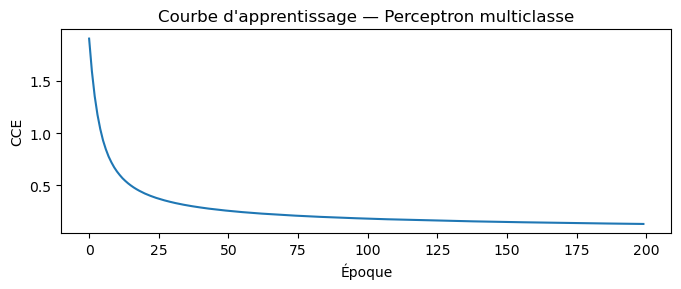

In [12]:
K = 10
W, b, loss_history = train_multiclass(
    X_train, y_train, K, lr=0.1, n_epochs=200, batch_size=64
)

fig, ax = plt.subplots(figsize=(7, 3))
ax.plot(loss_history)
ax.set_xlabel('Époque')
ax.set_ylabel('CCE')
ax.set_title("Courbe d'apprentissage — Perceptron multiclasse")
plt.tight_layout()
plt.show()

### 3.5 Évaluation

In [13]:
y_pred_train = np.argmax(forward(X_train, W, b), axis=1)
y_pred_test  = np.argmax(forward(X_test,  W, b), axis=1)

acc_multi_train = np.mean(y_pred_train == y_train)
acc_multi_test  = np.mean(y_pred_test  == y_test)

print(f'Accuracy train : {acc_multi_train:.3f}')
print(f'Accuracy test  : {acc_multi_test:.3f}')

Accuracy train : 0.978
Accuracy test  : 0.964


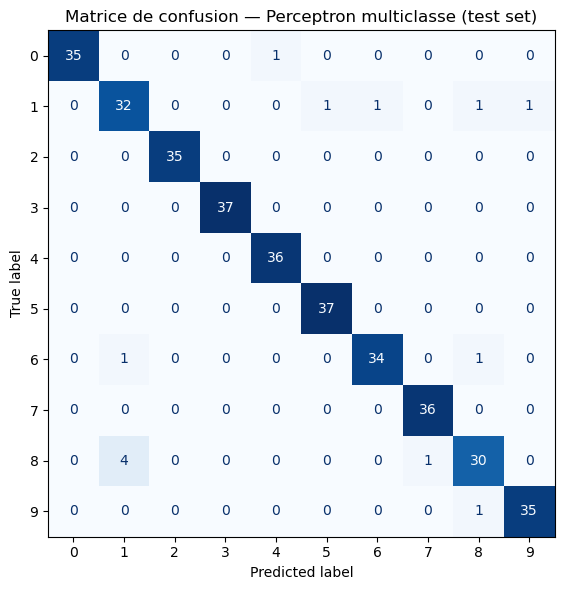

In [14]:
cm = confusion_matrix(y_test, y_pred_test)

fig, ax = plt.subplots(figsize=(7, 6))
disp = ConfusionMatrixDisplay(cm, display_labels=digits.target_names)
disp.plot(ax=ax, colorbar=False, cmap='Blues')
ax.set_title('Matrice de confusion — Perceptron multiclasse (test set)')
plt.tight_layout()
plt.show()

---
## Partie 4 — Comparaison avec scikit-learn

### 4.1 LogisticRegression

In [15]:
sk_model = LogisticRegression(max_iter=1000, random_state=42)
sk_model.fit(X_train, y_train)

sk_acc_train = sk_model.score(X_train, y_train)
sk_acc_test  = sk_model.score(X_test,  y_test)

print(f'sklearn — Accuracy train : {sk_acc_train:.3f}')
print(f'sklearn — Accuracy test  : {sk_acc_test:.3f}')

sklearn — Accuracy train : 0.987
sklearn — Accuracy test  : 0.956


### 4.2 Tableau comparatif

In [16]:
results = pd.DataFrame({
    'Méthode': [
        'Rosenblatt binaire (0 vs 1)',
        'Perceptron multiclasse (from scratch)',
        'sklearn LogisticRegression',
    ],
    'Accuracy test': [acc_bin_test, acc_multi_test, sk_acc_test],
}).set_index('Méthode').round(3)

results

,Accuracy test
Méthode,
Rosenblatt binaire (0 vs 1),0.986
Perceptron multiclasse (from scratch),0.964
sklearn LogisticRegression,0.956


---
## Conclusion

| Méthode | Accuracy test | Remarque |
|---|---|---|
| Rosenblatt binaire | ≈ 0.986 | Online, données linéairement séparables |
| Perceptron multiclasse | ≈ 0.964 | Mini-batch GD, K sorties + softmax |
| sklearn LogisticRegression | ≈ 0.956 | Référence L-BFGS |

> La formulation matricielle ($\mathbf{F} = \mathbf{X}\mathbf{W}^\top + \mathbf{b}$) et le gradient élégant $(\mathbf{P}-\mathbf{T})$ sont les briques directes de `nn.Linear` + `nn.CrossEntropyLoss` en PyTorch (J3).